In [29]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
import os
import open3d
import torch as t
import h5py
from io import StringIO
import matplotlib.patches as patches
from skimage.measure import regionprops
from skimage import filters
from numpy import linalg
import scipy
import pandas as pd

In [253]:
def getcen(el):
    centre = [linalg.det(el[:,[1,2,3]]), -linalg.det(el[:,[0,2,3]]), linalg.det(el[:,[0,1,3]])]/(-linalg.det(el[:,[0,1,2]]))
    return centre
def forwardproj(pcd, pr):
    pcd2 = np.concatenate((pcd, np.expand_dims(np.repeat(1, pcd.shape[0]), axis = 1)), axis=1)
    pcd2 = np.matmul(pcd2,pr.T)
    pcd2 = pcd2/np.repeat(np.expand_dims(pcd2[:,3], axis=1), 4, axis = 1)
    return(pcd2[:,:3])
def getcenf(el):
    centre = [linalg.det(el[:,[1,2,3]]), -linalg.det(el[:,[0,2,3]]), linalg.det(el[:,[0,1,3]]), -linalg.det(el[:,[0,1,2]])]
    return centre
def sf(fig, dirname):
    for i in ['.png', '.pdf']:
        fig.savefig('./'+dirname+'/'+str(int(os.listdir('./'+dirname+'/')[-1].split('.')[0])+1).zfill(3)+i)
#     fig.savefig('./'+dirname+'/'+str(int(os.listdir('./'+dirname+'/')[-1].split('.')[0])+1).zfill(3)+'.pdf')
#     return('./'+dirname+'/'+str(int(os.listdir('./'+dirname+'/')[-1].replace('.png',''))+1).zfill(3)+'.png')
def prmatread(path):
    with open(path, 'r') as f:
        prmatext = f.readlines()
    pr2 = [prmatext[i].replace('[','').replace(']','').replace(';','')\
           for i in range(len(prmatext))]
    pr3 = ''
    for i in pr2:
        pr3+=i
    pr4 = np.genfromtxt(StringIO(pr3), delimiter=',')
    return pr4
def outliers(ar):
    return(list(np.where(np.abs(ar-np.mean(ar)) > 6*np.std(ar))[0]))
def getstat(img):
    if isinstance(img, t.Tensor):
        tp = (float(t.min(img)), float(t.max(img)), float(t.mean(img)), float(t.std(img)))
    elif isinstance(img, np.ndarray):
        tp = (np.min(img), np.max(img), np.mean(img), np.std(img))
    return tp
def viewpoints(pcd, lims = None):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for i, p in enumerate(pcd):
        if p.shape[0] < p.shape[1]:
            p = p.T
        ax.scatter(p[:,0], p[:,1], p[:,2], c=colors[i], s=5) 
    if lims is not None:
        ax.set_xlim(lims[0], lims[1])
        ax.set_ylim(lims[0], lims[1])
        ax.set_zlim(lims[0], lims[1])
    return fig, ax

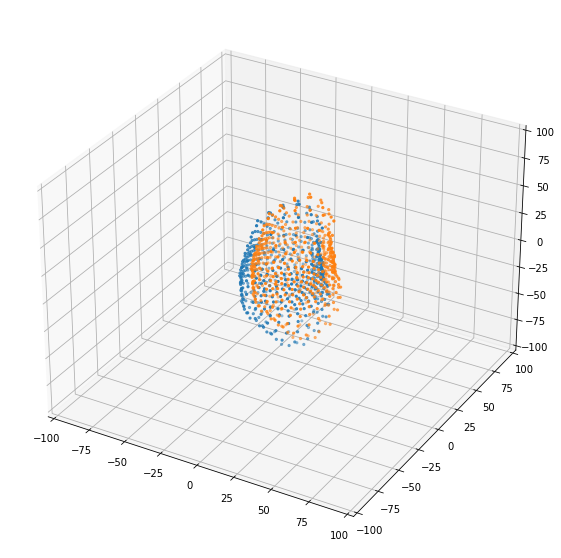

In [256]:
viewpoints([gt5, gt5+5], [-100, 100])

In [240]:
a = None

In [243]:
if a is None:
    print(a)

None


In [1087]:
F_Nw = np.array(h5py.File('C:/cherepashkin1/phenoseed_csv/598csv9_F_N.h5', 'r').get('dataset'))

In [1088]:
F_Nw.shape

(5270, 441)

In [5]:
df = pd.read_csv('C:/cherepashkin1/phenoseed_csv/598frame.csv')

In [6]:
df

,index,file_name,zero_angle,x_cms,y_cms,z_cms,delta_x,delta_y
0,0,598csv/1484717/1491988,8.0,129.831987,43.936533,154.317130,0.000000,0.000000
1,1,598csv/1484717/1491989,9.0,119.950786,48.513970,141.181489,0.040641,0.000000
2,2,598csv/1484717/1491990,8.0,123.014476,47.128630,155.613687,0.051783,0.516619
3,3,598csv/1484717/1491991,5.0,120.352368,42.278210,136.717018,0.032078,0.516619
4,4,598csv/1484717/1491992,11.0,120.963969,52.290549,139.462856,0.007131,0.688826
...,...,...,...,...,...,...,...,...
5278,5278,598csv/1484760/1500857,10.0,121.881008,24.875571,128.604963,-5.848818,0.516619
5279,5279,598csv/1484760/1500858,22.0,138.268651,47.324900,118.120206,-5.682811,0.516619
5280,5280,598csv/1484760/1500859,21.0,140.535355,24.351695,137.298298,-5.663254,0.516619
5281,5281,598csv/1484760/1500860,21.0,132.135006,52.008363,115.020311,-5.555135,0.516619


In [8]:
idx = [0,1,2,3]

In [31]:
cms = t.Tensor([df.loc[idx,'x_cms'].tolist(), df.loc[idx,'y_cms'].tolist(), df.loc[idx,'z_cms'].tolist()])

In [36]:
cms.T.shape

torch.Size([4, 3])

In [47]:
cms.T.repeat(500,1,1).permute(1, 2, 0).shape

torch.Size([4, 3, 500])

In [43]:
cms.T.repeat(500,1,1).shape

torch.Size([500, 4, 3])

In [40]:
cms.T.repeat(1,1,500).shape

torch.Size([1, 4, 1500])

In [55]:
GT = t.zeros([4,3,500])

In [56]:
GT.shape

torch.Size([4, 3, 500])

In [57]:
GT2 = GT+cms.T.repeat(500,1,1).permute(1, 2, 0)

In [60]:
a = 1 if True else 0

In [61]:
img = np.zeros([10, 1000, 1800])

In [64]:
type(int(1e20))

int

In [65]:
F_Nw.shape

NameError: name 'F_Nw' is not defined

In [67]:
a = t.zeros([1000]).cuda()

In [71]:
float(t.mean(a))

0.0

In [72]:
b = t.zeros([1000])

In [74]:
float(t.mean(b))

0.0

In [ ]:
GT = t.cat(
    (GT.reshape([GT.shape[0], 3, -1]),
     t.ones(nsp).repeat(GT.shape[0], 1, 1).cuda()),
    axis=1)
mat = t.einsum('ij, kij-> kij',
               basisminv, prmat[:, 0, :, :])
GT = t.einsum('ijk,ijn->ikn', GT, mat)
GT = (GT / t.unsqueeze(GT[:, 3], axis=1))[:, :, :3]
GT = t.transpose(GT, 1, 2)

In [75]:
gt = np.load('C:/cherepashkin1/598test/plot_output/gt.npy')

In [76]:
gt.shape

(4, 3, 500)

In [78]:
print(getstat(gt[0,0,:]))

(-27.473827, 26.775518, 0.41046998, 16.63134)


In [80]:
pcd = gt[0].T

In [81]:
pcd.shape

(500, 3)

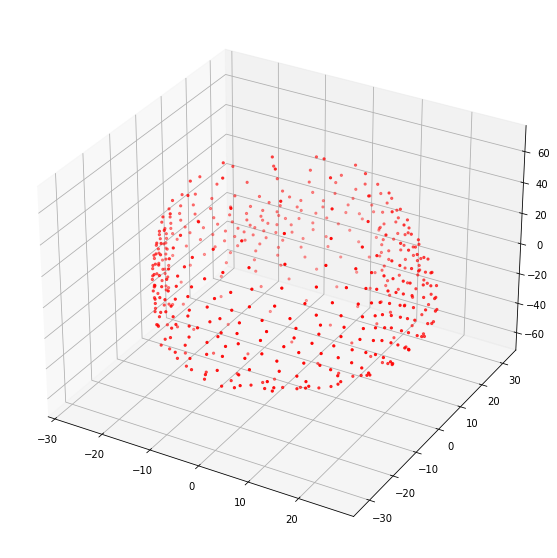

In [83]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(pcd[:,0], pcd[:,1], pcd[:,2], c='r', s=5)

In [86]:
prmatw = np.array(h5py.File('C:/cherepashkin1/phenoseed_csv/598prmat.h5'.replace('\\', '/'),
        'r').get('dataset'))

In [87]:
prmatw.shape

(5283, 36, 4, 4)

In [89]:
bigm = np.copy(prmatw)

In [90]:
bigm[:, :, 3, :] = np.repeat(np.repeat(np.expand_dims([0, 0, 0, 1],
    axis=(0, 1)), 36, axis=1), prmatw.shape[0], axis=0)

In [92]:
bigm[0,0,:,:]

array([[ 7.4039063e+02,  0.0000000e+00, -4.5703125e+01, -1.8280709e+05],
       [ 0.0000000e+00,  7.4039063e+02, -2.7218750e+01, -9.9071000e+04],
       [ 0.0000000e+00,  0.0000000e+00, -5.0781250e-02, -1.2100000e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [96]:
basisminv = linalg.inv(bigm[0,0,:,:])

In [98]:
mat = np.einsum('ij, kjn-> kin', basisminv, bigm[:4, 0, :, :])

In [100]:
print(gt.shape, mat.shape)

(4, 3, 500) (4, 4, 4)


In [139]:
gt2 = np.load('C:/cherepashkin1/598test/plot_output/gt2.npy')

In [127]:
gt2.shape

(2, 4, 500)

In [128]:
getstat(gt2[1,0,:])

(-23.640345, 25.145874, -0.2898684, 15.923265)

In [131]:
mat.shape

(4, 4, 4)

In [136]:
mat[:,:2,3]

array([[-2.84217094e-14,  0.00000000e+00],
       [ 4.06407088e-02,  0.00000000e+00],
       [ 5.17834754e-02,  5.16619180e-01],
       [ 3.20776615e-02,  5.16619180e-01]])

In [138]:
gt2.shape

(2, 4, 500)

In [140]:
gt3 = np.einsum('ijk,ijn->ikn', gt2, mat)

In [191]:
gt4 = np.matmul(mat[1,:,:],gt3[1,:,:].T)

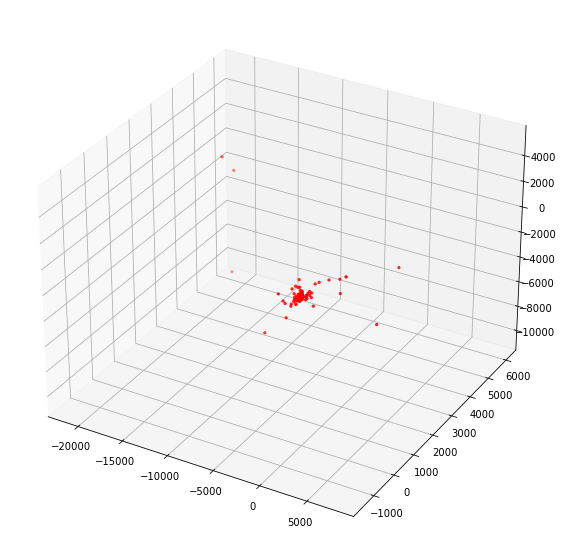

In [199]:
viewpoints(gt5.T)

In [192]:
gt4.shape

(4, 500)

In [193]:
gt5 = gt4/gt4[3,:]

In [194]:
getstat(gt4)

(-66.79576110839844, 60.30950927734375, -0.163403330475078, 16.699350617894552)

In [195]:
getstat(gt5)

(-21288.7915176297, 7747.505005763312, -21.294342201520863, 925.7337925217396)

In [144]:
gt3.shape

(4, 500, 4)

In [157]:
gt3[:,:,3].shape

(4, 500)

In [160]:
gt3[:,:,3]

array([[  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [  0.99999995,   0.91989116,   1.01351401, ...,   1.07307314,
          1.01874528,   0.99999995],
       [ 13.69703902,  13.82254797,  13.90905671, ..., -14.27761124,
        -13.66549298, -13.87405598],
       [ 14.43284259,  14.08103886,  14.23908998, ..., -13.54383464,
        -13.84998746, -13.93396465]])

In [162]:
gt3[0,:,3]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [171]:
gt3[0,4,3]

1.0000000000001323

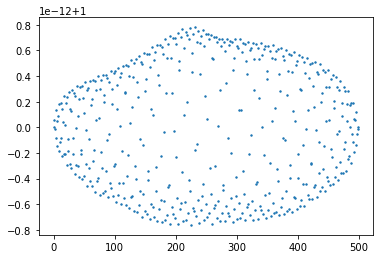

In [165]:
plt.scatter(np.arange(500),gt3[0,:,3], s=2)

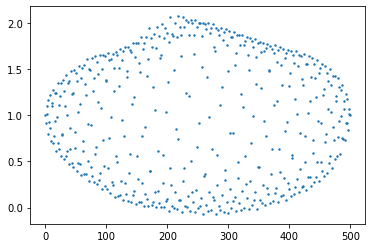

In [176]:
plt.scatter(np.arange(500),gt3[1,:,3], s=2)

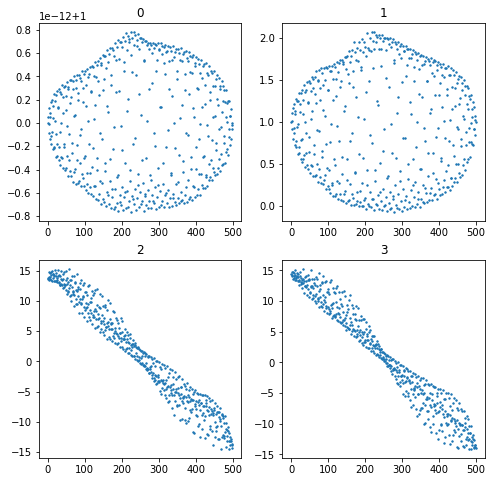

In [180]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
for i in range(4):
    ax0 = ax[i//2,i%2]
    ax0.scatter(np.arange(500),gt3[i,:,3], s=2)
    ax0.set_title(i)
sf(fig, 'figs')

In [154]:
dividor = np.copy(np.expand_dims(gt3[:, :, 3], axis=2))

In [151]:
GT = (gt3 / np.expand_dims(gt3[:, :, 3], axis=2))[:, :, :3]

In [155]:
GT2 = (gt3/ dividor)[:,:,:3]

In [152]:
GT.shape

(4, 500, 3)

In [141]:
gt3.shape

(4, 500, 4)

In [ ]:
[getstat(gt3[i,:,0]) for i in range(4)]

In [150]:
[getstat(gt3[i,:,0]) for i in range(4)]

[(-27.473827362060547,
  26.7755184173584,
  0.4104699727578927,
  16.631339912856077),
 (-26.294986724853516,
  26.43385887145996,
  -0.709084090964318,
  16.208365376768565),
 (-24.057130813598633,
  19.680147171020508,
  -0.5501116069272689,
  14.276741763501441),
 (-23.509933471679688,
  22.513689041137695,
  -0.7909906144311997,
  14.711680088505599)]

In [153]:
[getstat(GT[i,:,0]) for i in range(4)]

[(-27.473827362039092,
  26.775518417378777,
  0.4104699727657586,
  16.631339912856458),
 (-21288.83215833851,
  7747.4643650545,
  -113.51123488093054,
  1694.4534042948421),
 (-488.450242620898,
  383.7764087067956,
  -0.6313677241387111,
  37.45655831178821),
 (-244.88001762924196,
  523.6673238186252,
  2.033592684124266,
  35.64081565862832)]

In [156]:
[getstat(GT2[i,:,0]) for i in range(4)]

[(-27.473827362039092,
  26.775518417378777,
  0.4104699727657586,
  16.631339912856458),
 (-21288.83215833851,
  7747.4643650545,
  -113.51123488093054,
  1694.4534042948421),
 (-488.450242620898,
  383.7764087067956,
  -0.6313677241387111,
  37.45655831178821),
 (-244.88001762924196,
  523.6673238186252,
  2.033592684124266,
  35.64081565862832)]

In [ ]:
np.expand_dims(gt3[:, :, 3])

In [117]:
gt3[:,:,3].shape

(4, 500)

In [118]:
gt3.shape

(4, 500, 4)

In [119]:
gt3/gt3[:,:,3]

ValueError: operands could not be broadcast together with shapes (4,500,4) (4,500) 

In [113]:
gt3[:,3].shape

(4, 4)

In [111]:
np.expand_dims(gt3[:, 3], axis=1).shape

(4, 1, 4)

In [108]:
GT = np.transpose(GT, 1, 2)

TypeError: _transpose_dispatcher() takes from 1 to 2 positional arguments but 3 were given

In [107]:
GT.shape

(4, 500, 3)

In [109]:
getstat(GT[0,:,0])

(-9.356468579263257, 9.118652944272892, 0.13978938399182786, 5.663958183728428)

In [104]:
gt3.shape

(4, 500, 4)

In [95]:
bigm[2,0,:,:]

array([[ 7.4039063e+02,  0.0000000e+00, -4.5703125e+01, -1.8276875e+05],
       [ 0.0000000e+00,  7.4039063e+02, -2.7218750e+01, -9.8688500e+04],
       [ 0.0000000e+00,  0.0000000e+00, -5.0781250e-02, -1.2100000e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [121]:
a = np.random.rand(1000)

In [122]:
a.shape

(1000,)

In [123]:
getstat(a)

(2.3261377447791887e-05,
 0.9998720550241311,
 0.49508549906033533,
 0.28938413004478747)

In [125]:
getstat(10*a)

(0.00023261377447791887,
 9.99872055024131,
 4.950854990603354,
 2.8938413004478747)

In [201]:
bigm[0,0,:,:]

array([[ 7.4039063e+02,  0.0000000e+00, -4.5703125e+01, -1.8280709e+05],
       [ 0.0000000e+00,  7.4039063e+02, -2.7218750e+01, -9.9071000e+04],
       [ 0.0000000e+00,  0.0000000e+00, -5.0781250e-02, -1.2100000e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [202]:
mat1 = np.einsum('mij, nmjk->nmik',linalg.inv(bigm[0,:,:,:]), bigm)

In [204]:
mat1[1,0,:,:]

array([[ 1.00000000e+00,  0.00000000e+00, -6.93889390e-18,
         4.06407088e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [206]:
mat1.shape

(5283, 36, 4, 4)

In [207]:
mat2 = mat1[:4,0,:,:]

In [205]:
gt2.shape

(4, 4, 500)

In [208]:
gt3 = np.einsum('ijk,ijn->ikn', gt2, mat2)

In [215]:
gt3.shape

(4, 500, 4)

In [216]:
gt4 = gt3/np.expand_dims(gt3[:, :, 3], axis=2)

In [214]:
getstat(gt3[3,0,:])

(-1.1365590353307198e-06,
 26.001440048217773,
 10.1085700924732,
 10.904690191488307)

In [218]:
[getstat(gt4[i,0,:]) for i in range(4)]

[(-1.3462913557305e-06,
  30.799556732177734,
  7.949888509898756,
  13.198577438680251),
 (-1.2947167078027278e-06,
  29.619666704407628,
  7.654916028743553,
  12.687924357945011),
 (-7.843318661691184e-08,
  1.7943420613762489,
  0.6985854761274689,
  0.7529237616450634),
 (-7.874810716364038e-08,
  1.8015467069250974,
  0.7003866373572207,
  0.7555469492490945)]

In [235]:
[getstat(gt2[i,:,:]) for i in range(4)]

[(-62.48183, 67.15838, 0.12066148, 17.034822),
 (-66.79576, 60.30951, -0.16606648, 16.690405),
 (-57.60264, 59.75493, 0.15325326, 15.217997),
 (-60.301865, 61.298603, 0.15553851, 15.746603)]

In [237]:
[getstat(gt2[i,2,:]) for i in range(4)]

[(-62.48183, 67.15838, -0.19621566, 23.851755),
 (-66.79576, 60.30951, -0.6634922, 23.487366),
 (-57.60264, 59.75493, -0.20991403, 21.42247),
 (-60.301865, 61.298603, 0.10011273, 22.450825)]

In [219]:
gt2.shape

(4, 4, 500)

In [221]:
mat2.shape

(4, 4, 4)

In [228]:
mat2[0,:,:]

array([[ 1.00000000e+00,  0.00000000e+00, -6.93889390e-18,
        -2.84217094e-14],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [230]:
gt2 = np.load('C:/cherepashkin1/598test/plot_output/gt2.npy')

In [231]:
getstat(gt2[0,:,:])

(-62.48183, 67.15838, 0.12066148, 17.034822)

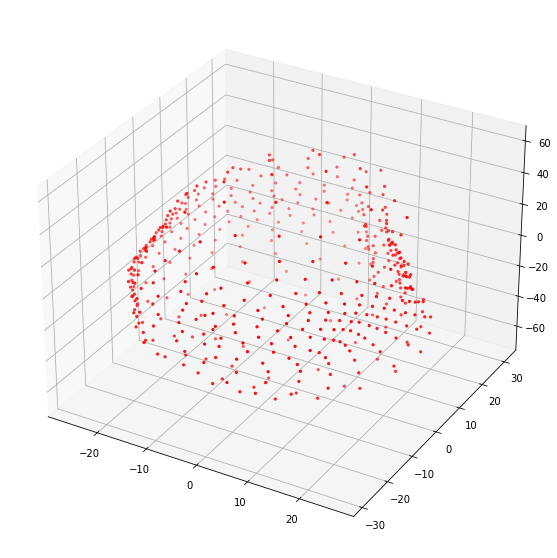

In [234]:
viewpoints(gt2[1,:,:].T)

In [245]:
gt5.shape

(4, 500)

In [239]:
getstat(gt5)

(-66.79576110839844,
 60.30950927734375,
 -0.15590611772327942,
 16.69008393567396)

In [260]:
mat2[2,:,:]

array([[ 1.00000000e+00,  0.00000000e+00, -6.93889390e-18,
         5.17834754e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         5.16619180e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [258]:
gt5 = np.matmul(mat2[2,:,:], gt2[2,:,:])

In [262]:
gt5.shape

(4, 500)

In [263]:
gt6 = gt5/gt5[3,:]

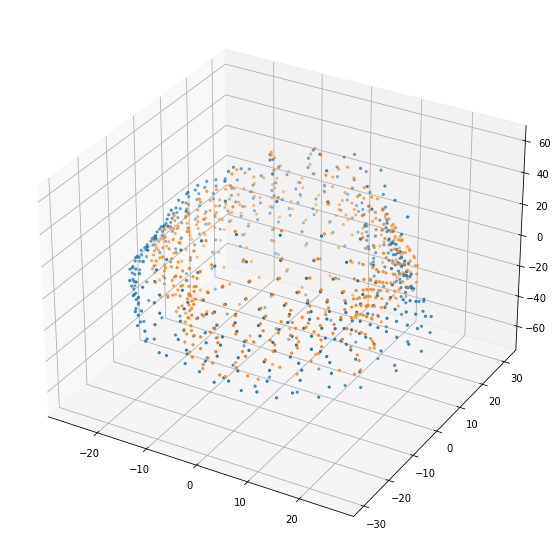

In [265]:
viewpoints([gt2[1,:,:], gt6])

In [261]:
mat2[:,:2,3]

array([[-2.84217094e-14,  0.00000000e+00],
       [ 4.06407088e-02,  0.00000000e+00],
       [ 5.17834754e-02,  5.16619180e-01],
       [ 3.20776615e-02,  5.16619180e-01]])

In [ ]:
for root, structure, files in os.walk('C:/cherepashkin1/phenoseed/598/'):

In [269]:
df.loc[3, 'file_name']

'598csv/1484717/1491991'

In [275]:
prmatw.shape

(5283, 36, 4, 4)

In [276]:
prmatw[0,0,:,:]

array([[ 7.4039063e+02,  0.0000000e+00, -4.5703125e+01, -1.8280709e+05],
       [ 0.0000000e+00,  7.4039063e+02, -2.7218750e+01, -9.9071000e+04],
       [ 0.0000000e+00,  0.0000000e+00, -5.0781250e-02, -1.2100000e+02],
       [ 0.0000000e+00,  0.0000000e+00, -5.0781250e-02, -1.2100000e+02]])

In [282]:
mat3 = np.einsum('ij, njk->nik', linalg.inv(bigm[0,0,:,:]), bigm[:,0,:,:])

In [283]:
mat3.shape

(5283, 4, 4)

In [ ]:
GT = gt2

In [291]:
nsp = 500

In [293]:
mat3.shape

(5283, 4, 4)

In [294]:
mat3t = t.Tensor(mat3).cuda()

In [299]:
GT.shape

torch.Size([4, 3, 500])

In [349]:
gt = np.load('C:/cherepashkin1/598test/plot_output/gt.npy')
GT = t.Tensor(gt).cuda()

In [384]:
GT.shape

torch.Size([5, 3, 500])

In [319]:
mat3[[1,2, 4],:,:]

array([[[ 1.00000000e+00,  0.00000000e+00, -6.93889390e-18,
          4.06407088e-02],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00, -6.93889390e-18,
          5.17834754e-02],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          5.16619180e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00, -6.93889390e-18,
          7.13137064e-03],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          6.88825573e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+

In [364]:
gt[1,:,:].shape

(3, 500)

In [366]:
gtt = forwardproj(gt[1,:,:].T, mat3[1,:,:])

In [367]:
gtt.shape

(500, 3)

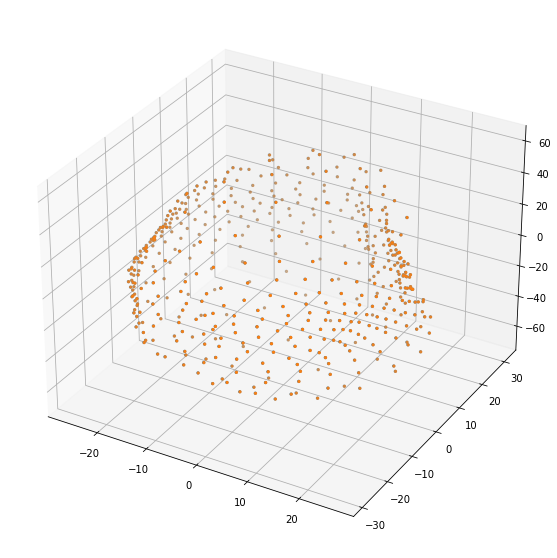

In [370]:
viewpoints([gt[1,:,:],gtt])

In [378]:
pcd.shape

(25567, 3)

In [389]:
print(mat3[1,:,:])

[[ 1.00000000e+00  0.00000000e+00 -6.93889390e-18  4.06407088e-02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [399]:
dif = pcd2[:,:3]-pcd

In [410]:
pcd2.shape

(500, 4)

In [411]:
np.min(pcd2[:,0])-np.min(pcd[:,0])

0.04064070881065618

In [ ]:
dif[:,0]

In [ ]:
(-66.79576110839844, 60.30950927734375, -0.6634923219680786, 23.510889053344727)

In [ ]:
viewpoints([gt[1,:,:],pcd2])

In [371]:
GT.shape[0]

5

In [372]:
GT.shape

torch.Size([5, 3, 500])

In [376]:
t.ones(nsp).repeat(GT.shape[0], 1, 1).shape

torch.Size([5, 1, 500])

In [422]:
pcd = gt[1,:,:].T
print(getstat(pcd[:,0]))
pr = mat3[1,:,:]
# print(pr)
# pcd1 = np.copy(pcd)
pcd2 = np.concatenate((pcd, np.expand_dims(np.repeat(1, pcd.shape[0]), axis = 1)), axis=1)
pcd2 = np.matmul(pcd2,pr.T)
# print(pcd2.shape)
pcd2 = pcd2/np.repeat(np.expand_dims(pcd2[:,3], axis=1), 4, axis = 1)
print(getstat(pcd2[:,0]))

(-26.294987, 26.433859, -0.70908415, 16.208364)
(-26.25434601604286, 26.474499580270617, -0.6684433821536618, 16.208365376768565)


In [438]:
GT2 = t.cat((GT,t.ones(nsp).repeat(GT.shape[0], 1, 1).cuda()),axis=1)
print(GT2.shape)
print(getstat(GT2[1,0,:]))
# print(mat3t.shape)
# print(GT2[0,3,:])
# print(prmat.shape)
# mat = t.einsum('ij, kjn-> kin',
#                basisminv, prmat[:, 0, :, :])
# print(mat)
# GT = t.einsum('ijk,ikn->ijn', GT, mat)
# np.save('C:/cherepashkin1/598test/plot_output/gt2.npy', GT.detach().cpu().numpy())
# print(mat3t[1,:,:])
gt6 = t.matmul(GT2[1,:,:].T,mat3t[1,:,:].T)
# print(gt6.shape)
# print('gt6', getstat(gt6[:,0]))

# GT3 = t.einsum('ijk,ijn->ikn', GT2, mat3t[:5,:,:])
GT3 = t.einsum('nji,nkj->nik', GT2, mat3t[:5,:,:])
# print(GT3.shape)
# print('GT3', getstat(GT3[1,:,0]))

# print(GT2.shape, mat3t.shape)
# GT4 = t.einsum('ji,kj->ik', GT2[1,:,:], mat3t[1,:,:])
# print(GT4.shape)
# print('GT4', getstat(GT4[:,0]))

# print(GT.shape)
GT5 = (GT3 / t.unsqueeze(GT3[:, :, 3], axis=2))[:, :, :3]
GT5 = t.transpose(GT3, 1, 2)
print(GT5.shape)
print(getstat(GT5[1,0,:]))

torch.Size([5, 4, 500])
(-26.294986724853516, 26.43385887145996, -0.709084153175354, 16.224597930908203)
torch.Size([5, 4, 500])
(-26.25434684753418, 26.474498748779297, -0.6684437394142151, 16.224597930908203)


In [ ]:
GT2 = t.cat((GT,t.ones(nsp).repeat(GT.shape[0], 1, 1).cuda()),axis=1)
GT3 = t.einsum('nji,nkj->nik', GT2, mat3t[:5,:,:])
GT5 = (GT3 / t.unsqueeze(GT3[:, :, 3], axis=2))[:, :, :3]
GT5 = t.transpose(GT3, 1, 2)

In [ ]:
gt6 = np.matmul(GT2,pr.T)

In [308]:
GT.shape

torch.Size([4, 3, 500])

In [314]:
GT2.shape

torch.Size([4, 500, 3])

In [318]:
getstat(GT2[4,:,2])

IndexError: index 4 is out of bounds for dimension 0 with size 4

(25567, 4)
[120.35236829  42.27821019 136.71701803   1.        ]


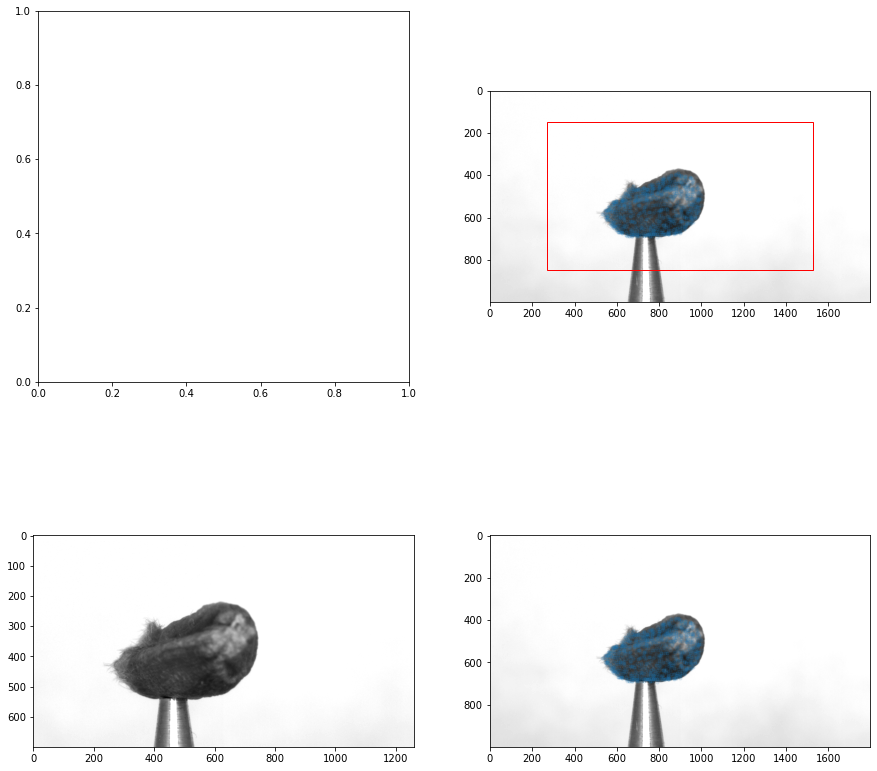

In [284]:
h = 1000
hc = 700
hn = 250
angle = 0
w, wc, wn = h*1.8, hc*1.8, hn*1.8
k = hn/hc
mu=1
# flname = '1484758/1500562'
index = 3
flname = df.loc[index, 'file_name'].replace('598csv', '')
img = np.asarray(io.imread('C:/cherepashkin1/phenoseed/598/'+flname+'/rotation_'+str(10*angle).zfill(3)+'.tif'))
pcd = np.asarray(open3d.io.read_point_cloud('C:/cherepashkin1/phenoseed/598/'+flname+'_Surface.ply').points)
prmat = prmatread('C:/cherepashkin1/phenoseed/598/'+flname+'_ProjectionMatrices.txt')
new_h = 700
new_w = 1260
img0 = 255-img
cms = [int(h/2), int(w/2)]
tempa = (img[cms[0] - new_h//2: cms[0] + new_h//2,
         cms[1] - new_w//2: cms[1] + new_w//2]).astype(np.uint8)
padh = (new_h-tempa.shape[0])//2
padw = (new_w-tempa.shape[1])//2
tempb = np.pad(
    tempa, ((padh, new_h-tempa.shape[0]-padh),
            (padw, new_w-tempa.shape[1]-padw)),
    mode='constant', constant_values=0)
new_img = np.squeeze(
    transform.resize(tempb,(250, 450),
        preserve_range=True))
pr0 = prmat[angle*4:4*(angle+1),:]
f, ((a0, a1), (a2, a3)) = plt.subplots(2, 2, figsize=(15,15))
pcd1 = np.concatenate((pcd, np.expand_dims(np.repeat(1,
    pcd.shape[0]), axis = 1)), axis=1)
pcd1 = np.matmul(pcd1,pr0.T)
pcd1 = pcd1/np.repeat(np.expand_dims(pcd1[:,3], axis=1), 4, axis = 1)
print(pcd1.shape)
origin = np.hstack((np.mean(pcd,axis=0),1))
print(origin)
origin1 = np.matmul(origin,pr0.T)
origin2 = origin1/origin1[3]
a0.set_aspect('equal', adjustable='box')
a1.imshow(img, cmap='gray')
a1.scatter(pcd1[::25,0], pcd1[::25,1], alpha = 0.1, s=10)
a1.add_patch(patches.Rectangle((cms[1]-1260/2, cms[0]-700/2), 1260, 700, linewidth=1, edgecolor='r', facecolor='none'))
pcd2 = forwardproj(pcd,mat3[index,:,:])
# pcd2 = forwardproj(pcd,np.matmul(linalg.inv(bigm[0,0,:,:]), bigm[index,0,:,:]))
pcd3 = forwardproj(pcd2,prmatw[0,0,:,:])
a2.imshow(tempb, cmap='gray')
a3.imshow(img, cmap='gray')
a3.scatter(pcd3[::25,0], pcd3[::25,1], alpha = 0.1, s=10)

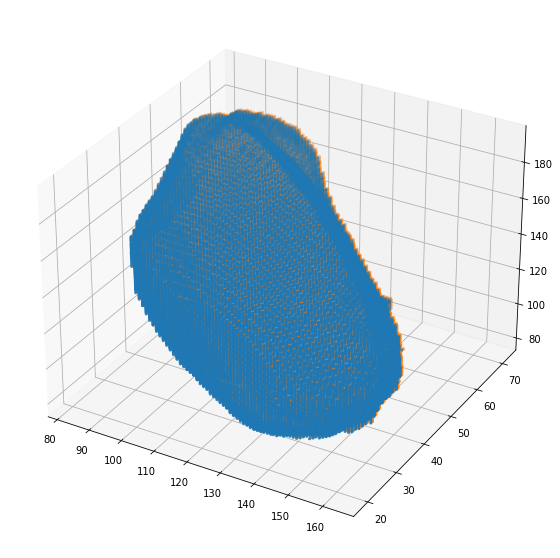

In [279]:
viewpoints([pcd, pcd2])

In [339]:
a, b, c = [np.zeros(1), np.zeros(2), np.zeros(3)]

In [334]:
[2*i for i in [a, b, c]]

[2, 4, 6]

In [340]:
lst = a, b, c

In [341]:
lst

(array([0.]), array([0., 0.]), array([0., 0., 0.]))

In [342]:
lst2 = [t.Tensor(i) for i in lst]

In [343]:
lst2 

[tensor([0.]), tensor([0., 0.]), tensor([0., 0., 0.])]

In [329]:
a, b, c = [t.Tensor(i) for i in [a, b, c]]

In [330]:
a

tensor([])

In [439]:
y = t.transpose(0, 1) # y is non-contiguous

TypeError: transpose() received an invalid combination of arguments - got (int, int), but expected one of:
 * (Tensor input, int dim0, int dim1)
 * (Tensor input, name dim0, name dim1)


In [440]:
5%0

ZeroDivisionError: integer division or modulo by zero

In [465]:
1000//111.11111111111111

8.0

In [456]:
1000//111.1111111111111111111111111111111

8.0

In [468]:
100%(100)

0

In [466]:
for i in np.arange(0.01, 0.99, 0.01):
    print(i, int(1/i)-1)
    print(i, 1000//(i*1000/(1-i)))

0.01 99
0.01 99.0
0.02 49
0.02 49.0
0.03 32
0.03 32.0
0.04 24
0.04 23.0
0.05 19
0.05 18.0
0.060000000000000005 15
0.060000000000000005 15.0
0.06999999999999999 13
0.06999999999999999 13.0
0.08 11
0.08 11.0
0.09 10
0.09 10.0
0.09999999999999999 9
0.09999999999999999 9.0
0.11 8
0.11 8.0
0.12 7
0.12 7.0
0.13 6
0.13 6.0
0.14 6
0.14 6.0
0.15000000000000002 5
0.15000000000000002 5.0
0.16 5
0.16 5.0
0.17 4
0.17 4.0
0.18000000000000002 4
0.18000000000000002 4.0
0.19 4
0.19 4.0
0.2 4
0.2 4.0
0.21000000000000002 3
0.21000000000000002 3.0
0.22 3
0.22 3.0
0.23 3
0.23 3.0
0.24000000000000002 3
0.24000000000000002 3.0
0.25 3
0.25 3.0
0.26 2
0.26 2.0
0.27 2
0.27 2.0
0.28 2
0.28 2.0
0.29000000000000004 2
0.29000000000000004 2.0
0.3 2
0.3 2.0
0.31 2
0.31 2.0
0.32 2
0.32 2.0
0.33 2
0.33 2.0
0.34 1
0.34 1.0
0.35000000000000003 1
0.35000000000000003 1.0
0.36000000000000004 1
0.36000000000000004 1.0
0.37 1
0.37 1.0
0.38 1
0.38 1.0
0.39 1
0.39 1.0
0.4 1
0.4 1.0
0.41000000000000003 1
0.41000000000000003 1.0


In [469]:
y_n = np.genfromtxt('C:/cherepashkin1/phenoseed_csv/Y_N_500.csv')

In [470]:
y_n.shape

(18000,)